In [1]:
# =========================
# Fixed Income Portfolio Monitoring Dashboard (MVP)
# Mode B: fixed shares holdings
# Jupyter-ready, end-to-end
# =========================

# ---- 0) Install & imports (run once)

import pandas as pd
import numpy as np
import yfinance as yf

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# ---- 1) Config
TICKERS = ["AGG","IEF","TLT","LQD","HYG","TIP","BIL"]
START = "2024-01-01"
END = None                 # None = to latest
BASE_CCY = "USD"           # yfinance prices are USD for these ETFs

PORTFOLIO_ID = "DEMO_FI"
BENCHMARK_ID = "US_CORE_PROXY"

# Fixed shares (Mode B) - you can change these numbers
FIXED_SHARES = {
    "AGG": 120,
    "IEF": 80,
    "TLT": 30,
    "LQD": 60,
    "HYG": 40,
    "TIP": 25,
    "BIL": 60
}

# Duration map (rough constants; you can later update monthly or scrape issuers)
DURATION_MAP = {
    "AGG": 6.2,
    "IEF": 7.5,
    "TLT": 16.8,
    "LQD": 8.3,
    "HYG": 3.8,
    "TIP": 7.0,
    "BIL": 0.1
}

# Benchmark weights (proxy; should sum to 1.0)
BENCHMARK_WEIGHTS = {
    "AGG": 0.45,
    "IEF": 0.20,
    "LQD": 0.20,
    "TIP": 0.10,
    "BIL": 0.05
}

# Limits / rules (simple demo; tune to your taste)
LIMITS = {
    "MAX_SINGLE_NAME_WEIGHT": 0.35,   # e.g., single holding not above 35%
    "DURATION_LOW": 4.0,
    "DURATION_HIGH": 8.0,
    "MIN_CASH_WEIGHT": 0.03,          # cash proxy (BIL) at least 3%
    "ACTIVE_WEIGHT_WARN": 0.05,       # warn if |active weight| > 5%
}

# ---- 2) Security master (small, curated; you can expand)
security_master = pd.DataFrame([
    {"sid":"AGG","ticker":"AGG","name":"Core U.S. Aggregate","asset_class":"BondETF","currency":"USD","country":"US","sector":"Aggregate","rating_bucket":"Core","benchmark_group":"US_CORE"},
    {"sid":"IEF","ticker":"IEF","name":"UST 7-10Y","asset_class":"BondETF","currency":"USD","country":"US","sector":"Government","rating_bucket":"AAA","benchmark_group":"US_RATES"},
    {"sid":"TLT","ticker":"TLT","name":"UST 20Y+","asset_class":"BondETF","currency":"USD","country":"US","sector":"Government","rating_bucket":"AAA","benchmark_group":"US_RATES"},
    {"sid":"LQD","ticker":"LQD","name":"IG Credit","asset_class":"BondETF","currency":"USD","country":"US","sector":"IG_Credit","rating_bucket":"IG","benchmark_group":"US_CREDIT"},
    {"sid":"HYG","ticker":"HYG","name":"HY Credit","asset_class":"BondETF","currency":"USD","country":"US","sector":"HY_Credit","rating_bucket":"HY","benchmark_group":"US_CREDIT"},
    {"sid":"TIP","ticker":"TIP","name":"TIPS","asset_class":"BondETF","currency":"USD","country":"US","sector":"Inflation_Linked","rating_bucket":"AAA","benchmark_group":"US_INFL"},
    {"sid":"BIL","ticker":"BIL","name":"T-Bills (Cash proxy)","asset_class":"CashETF","currency":"USD","country":"US","sector":"Cash","rating_bucket":"AAA","benchmark_group":"US_CASH"},
])

# ---- 3) Download market prices (Adj Close via auto_adjust)
px = yf.download(TICKERS, start=START, end=END, auto_adjust=True, progress=False)["Close"]
px = px.dropna(how="all")
px = px.dropna(axis=1, how="any")  # keep only tickers with full data coverage

# Align universe if any ticker dropped
available = list(px.columns)
missing = sorted(set(TICKERS) - set(available))
if missing:
    print("Warning: missing tickers from price data:", missing)

TICKERS_USE = available

# ---- 4) Build daily positions from fixed shares
shares = pd.Series({k: v for k, v in FIXED_SHARES.items() if k in TICKERS_USE}).rename("quantity")
shares.index.name = "sid"

# daily market value per sid
mv = px.mul(shares, axis=1)  # market value in USD
total_mv = mv.sum(axis=1)

weights = mv.div(total_mv, axis=0)

# ---- 5) Risk factors (duration + DV01 approximation)
# Duration per sid
dur = pd.Series({k: DURATION_MAP.get(k, np.nan) for k in TICKERS_USE}, name="duration")
# portfolio duration = sum(weight_i * duration_i)
port_duration = weights.mul(dur, axis=1).sum(axis=1)

# DV01 approximation per sid: duration * MV * 1bp (0.0001)
dv01 = mv.mul(dur, axis=1) * 1e-4
port_dv01 = dv01.sum(axis=1)

# ---- 6) Benchmark weights (proxy) and active weights
bm_w = pd.Series({k: BENCHMARK_WEIGHTS.get(k, 0.0) for k in TICKERS_USE}, name="bm_weight")

# Normalize benchmark weights in case you provided weights for tickers that were missing
if bm_w.sum() > 0:
    bm_w = bm_w / bm_w.sum()

active_w = weights.sub(bm_w, axis=1)

# Benchmark duration & duration active
bm_duration = (bm_w * dur).sum()
duration_active = port_duration - bm_duration

# ---- 7) Build “today” snapshot tables (latest date)
asof = px.index.max()

today_positions = pd.DataFrame({
    "date": asof,
    "portfolio_id": PORTFOLIO_ID,
    "sid": TICKERS_USE,
    "quantity": shares.reindex(TICKERS_USE).values,
    "price": px.loc[asof].values,
    "market_value": mv.loc[asof].values,
    "weight": weights.loc[asof].values,
    "bm_weight": bm_w.reindex(TICKERS_USE).values,
    "active_weight": active_w.loc[asof].values,
    "duration": dur.reindex(TICKERS_USE).values,
    "dv01": dv01.loc[asof].values,
})

today_positions = today_positions.merge(security_master, on="sid", how="left")
today_positions = today_positions.sort_values("weight", ascending=False).reset_index(drop=True)

# Portfolio summary
portfolio_summary = pd.DataFrame([{
    "date": asof,
    "portfolio_id": PORTFOLIO_ID,
    "aum_market_value": float(total_mv.loc[asof]),
    "portfolio_duration": float(port_duration.loc[asof]),
    "benchmark_duration": float(bm_duration),
    "duration_active": float(duration_active.loc[asof]),
    "portfolio_dv01": float(port_dv01.loc[asof]),
}])

# Exposure summaries
sector_exposure = today_positions.groupby("sector", dropna=False)["weight"].sum().sort_values(ascending=False).to_frame("weight")
rating_exposure = today_positions.groupby("rating_bucket", dropna=False)["weight"].sum().sort_values(ascending=False).to_frame("weight")

# ---- 8) Alerts engine (simple, readable, portfolio-ops style)
alerts = []

def add_alert(alert_type, severity, sid, message, value=None, threshold=None):
    alerts.append({
        "date": asof,
        "portfolio_id": PORTFOLIO_ID,
        "severity": severity,
        "alert_type": alert_type,
        "sid": sid,
        "message": message,
        "value": value,
        "threshold": threshold
    })

# Rule: single name weight
max_w = LIMITS["MAX_SINGLE_NAME_WEIGHT"]
over_single = today_positions[today_positions["weight"] > max_w]
for _, r in over_single.iterrows():
    add_alert(
        alert_type="RULE_BREACH_SINGLE_NAME",
        severity="BREACH",
        sid=r["sid"],
        message=f"Single-name weight exceeds limit ({r['sid']} weight {r['weight']:.2%} > {max_w:.2%}).",
        value=float(r["weight"]),
        threshold=max_w
    )

# Rule: minimum cash (using BIL as cash proxy)
min_cash = LIMITS["MIN_CASH_WEIGHT"]
bil_row = today_positions[today_positions["sid"] == "BIL"]
bil_w = float(bil_row["weight"].iloc[0]) if len(bil_row) else 0.0
if bil_w < min_cash:
    add_alert(
        alert_type="RULE_BREACH_MIN_CASH",
        severity="WARN",
        sid="BIL",
        message=f"Cash proxy weight below minimum (BIL {bil_w:.2%} < {min_cash:.2%}).",
        value=bil_w,
        threshold=min_cash
    )

# Rule: duration range
d_low, d_high = LIMITS["DURATION_LOW"], LIMITS["DURATION_HIGH"]
pdur = float(port_duration.loc[asof])
if pdur < d_low:
    add_alert(
        alert_type="RULE_BREACH_DURATION",
        severity="BREACH",
        sid=None,
        message=f"Portfolio duration below range ({pdur:.2f} < {d_low:.2f}).",
        value=pdur,
        threshold=d_low
    )
if pdur > d_high:
    add_alert(
        alert_type="RULE_BREACH_DURATION",
        severity="BREACH",
        sid=None,
        message=f"Portfolio duration above range ({pdur:.2f} > {d_high:.2f}).",
        value=pdur,
        threshold=d_high
    )

# Active weight warnings
aw_warn = LIMITS["ACTIVE_WEIGHT_WARN"]
aw_extreme = today_positions[abs(today_positions["active_weight"]) > aw_warn].copy()
aw_extreme["abs_active"] = aw_extreme["active_weight"].abs()
aw_extreme = aw_extreme.sort_values("abs_active", ascending=False)
for _, r in aw_extreme.iterrows():
    add_alert(
        alert_type="ACTIVE_WEIGHT_DEVIATION",
        severity="WARN",
        sid=r["sid"],
        message=f"Active weight large ({r['sid']} active {r['active_weight']:.2%}, threshold {aw_warn:.2%}).",
        value=float(r["active_weight"]),
        threshold=aw_warn
    )

alerts_df = pd.DataFrame(alerts).sort_values(["severity","alert_type"], ascending=[True, True]).reset_index(drop=True)

# ---- 9) Show outputs (these are what you demo in the portfolio)
print("=== Portfolio Summary (as of) ===")
display(portfolio_summary)

print("\n=== Top Holdings (as of) ===")
display(today_positions[["sid","name","sector","rating_bucket","quantity","price","market_value","weight","bm_weight","active_weight","duration","dv01"]].head(10))

print("\n=== Active Weights (sorted by abs active) ===")
tmp_aw = today_positions[["sid","name","weight","bm_weight","active_weight"]].copy()
tmp_aw["abs_active"] = tmp_aw["active_weight"].abs()
display(tmp_aw.sort_values("abs_active", ascending=False).drop(columns=["abs_active"]).head(10))

print("\n=== Sector Exposure ===")
display(sector_exposure)

print("\n=== Rating Bucket Exposure ===")
display(rating_exposure)

print("\n=== Alerts ===")
display(alerts_df if len(alerts_df) else pd.DataFrame([{
    "date": asof, "portfolio_id": PORTFOLIO_ID, "severity": "INFO",
    "alert_type": "NO_ALERTS", "sid": None, "message": "No alerts triggered.", "value": None, "threshold": None
}]))

# ---- 10) (Optional) Export tables for your repo / Streamlit app later
OUT_DIR = "fi_monitor_outputs"
import os
os.makedirs(OUT_DIR, exist_ok=True)

today_positions.to_csv(f"{OUT_DIR}/today_positions.csv", index=False)
portfolio_summary.to_csv(f"{OUT_DIR}/portfolio_summary.csv", index=False)
sector_exposure.reset_index().to_csv(f"{OUT_DIR}/sector_exposure.csv", index=False)
rating_exposure.reset_index().to_csv(f"{OUT_DIR}/rating_exposure.csv", index=False)
alerts_df.to_csv(f"{OUT_DIR}/alerts.csv", index=False)

print(f"\nSaved outputs to ./{OUT_DIR}/")


=== Portfolio Summary (as of) ===


,date,portfolio_id,aum_market_value,portfolio_duration,benchmark_duration,duration_active,portfolio_dv01
0,2026-02-04,DEMO_FI,40249.782944,6.5056,6.655,-0.1494,26.184897



=== Top Holdings (as of) ===


,sid,name,sector,rating_bucket,quantity,price,market_value,weight,bm_weight,active_weight,duration,dv01
0,AGG,Core U.S. Aggregate,Aggregate,Core,120,99.629898,11955.587769,0.297035,0.45,-0.152965,6.2,7.412464
1,IEF,UST 7-10Y,Government,AAA,80,95.455002,7636.400146,0.189725,0.20,-0.010275,7.5,5.727300
2,LQD,IG Credit,IG_Credit,IG,60,109.879501,6592.770081,0.163796,0.20,-0.036204,8.3,5.471999
3,BIL,T-Bills (Cash proxy),Cash,AAA,60,91.404999,5484.299927,0.136257,0.05,0.086257,0.1,0.054843
4,HYG,HY Credit,HY_Credit,HY,40,80.675003,3227.000122,0.080174,0.00,0.080174,3.8,1.226260
5,TIP,TIPS,Inflation_Linked,AAA,25,110.294998,2757.374954,0.068507,0.10,-0.031493,7.0,1.930162
6,TLT,UST 20Y+,Government,AAA,30,86.544998,2596.349945,0.064506,0.00,0.064506,16.8,4.361868



=== Active Weights (sorted by abs active) ===


,sid,name,weight,bm_weight,active_weight
0,AGG,Core U.S. Aggregate,0.297035,0.45,-0.152965
3,BIL,T-Bills (Cash proxy),0.136257,0.05,0.086257
4,HYG,HY Credit,0.080174,0.00,0.080174
6,TLT,UST 20Y+,0.064506,0.00,0.064506
2,LQD,IG Credit,0.163796,0.20,-0.036204
5,TIP,TIPS,0.068507,0.10,-0.031493
1,IEF,UST 7-10Y,0.189725,0.20,-0.010275



=== Sector Exposure ===


,weight
sector,
Aggregate,0.297035
Government,0.254231
IG_Credit,0.163796
Cash,0.136257
HY_Credit,0.080174
Inflation_Linked,0.068507



=== Rating Bucket Exposure ===


,weight
rating_bucket,
AAA,0.458994
Core,0.297035
IG,0.163796
HY,0.080174



=== Alerts ===


,date,portfolio_id,severity,alert_type,sid,message,value,threshold
0,2026-02-04,DEMO_FI,WARN,ACTIVE_WEIGHT_DEVIATION,AGG,"Active weight large (AGG active -15.30%, thres...",-0.152965,0.05
1,2026-02-04,DEMO_FI,WARN,ACTIVE_WEIGHT_DEVIATION,BIL,"Active weight large (BIL active 8.63%, thresho...",0.086257,0.05
2,2026-02-04,DEMO_FI,WARN,ACTIVE_WEIGHT_DEVIATION,HYG,"Active weight large (HYG active 8.02%, thresho...",0.080174,0.05
3,2026-02-04,DEMO_FI,WARN,ACTIVE_WEIGHT_DEVIATION,TLT,"Active weight large (TLT active 6.45%, thresho...",0.064506,0.05



Saved outputs to ./fi_monitor_outputs/


In [2]:
# =========================
# One-click Jupyter version:
# - No manual folders/CSV needed
# - Auto-create data + outputs
# - Download market prices
# - Build monitoring tables + alerts
# =========================

!pip -q install yfinance pandas numpy

import os
import pandas as pd
import numpy as np
import yfinance as yf

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# ---------- Config ----------
TICKERS = ["AGG","IEF","TLT","LQD","HYG","TIP","BIL"]
START = "2024-01-01"
END = None

PORTFOLIO_ID = "DEMO_FI"
BENCHMARK_ID = "US_CORE_PROXY"

# Mode B: fixed shares
FIXED_SHARES = {
    "AGG": 120,
    "IEF": 80,
    "TLT": 30,
    "LQD": 60,
    "HYG": 40,
    "TIP": 25,
    "BIL": 60
}

# Proxy benchmark weights
BENCHMARK_WEIGHTS = {
    "AGG": 0.45,
    "IEF": 0.20,
    "LQD": 0.20,
    "TIP": 0.10,
    "BIL": 0.05
}

# Monthly duration (demo: 2 months; you can extend later)
DURATION_MONTHLY = [
    ("2026-01-01","AGG",6.20), ("2026-01-01","IEF",7.50), ("2026-01-01","TLT",16.80),
    ("2026-01-01","LQD",8.30), ("2026-01-01","HYG",3.80), ("2026-01-01","TIP",7.00), ("2026-01-01","BIL",0.10),
    ("2026-02-01","AGG",6.15), ("2026-02-01","IEF",7.45), ("2026-02-01","TLT",16.70),
    ("2026-02-01","LQD",8.25), ("2026-02-01","HYG",3.85), ("2026-02-01","TIP",6.95), ("2026-02-01","BIL",0.10),
]

# Limits / rules
LIMITS = {
    "MAX_SINGLE_NAME_WEIGHT": 0.35,
    "DURATION_LOW": 4.0,
    "DURATION_HIGH": 8.0,
    "MIN_CASH_WEIGHT": 0.03,       # treat BIL as cash proxy
    "ACTIVE_WEIGHT_WARN": 0.05,
}

# ---------- Auto-create folders ----------
DATA_DIR = "data"
OUT_DIR = "outputs"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Build security master (in-memory + save) ----------
security_master = pd.DataFrame([
    {"sid":"AGG","ticker":"AGG","name":"Core U.S. Aggregate","asset_class":"BondETF","currency":"USD","country":"US","sector":"Aggregate","rating_bucket":"Core","benchmark_group":"US_CORE"},
    {"sid":"IEF","ticker":"IEF","name":"UST 7-10Y","asset_class":"BondETF","currency":"USD","country":"US","sector":"Government","rating_bucket":"AAA","benchmark_group":"US_RATES"},
    {"sid":"TLT","ticker":"TLT","name":"UST 20Y+","asset_class":"BondETF","currency":"USD","country":"US","sector":"Government","rating_bucket":"AAA","benchmark_group":"US_RATES"},
    {"sid":"LQD","ticker":"LQD","name":"IG Credit","asset_class":"BondETF","currency":"USD","country":"US","sector":"IG_Credit","rating_bucket":"IG","benchmark_group":"US_CREDIT"},
    {"sid":"HYG","ticker":"HYG","name":"HY Credit","asset_class":"BondETF","currency":"USD","country":"US","sector":"HY_Credit","rating_bucket":"HY","benchmark_group":"US_CREDIT"},
    {"sid":"TIP","ticker":"TIP","name":"TIPS","asset_class":"BondETF","currency":"USD","country":"US","sector":"Inflation_Linked","rating_bucket":"AAA","benchmark_group":"US_INFL"},
    {"sid":"BIL","ticker":"BIL","name":"T-Bills (Cash proxy)","asset_class":"CashETF","currency":"USD","country":"US","sector":"Cash","rating_bucket":"AAA","benchmark_group":"US_CASH"},
])
security_master.to_csv(f"{DATA_DIR}/security_master.csv", index=False)

# ---------- Build duration monthly (in-memory + save) ----------
duration_monthly = pd.DataFrame(DURATION_MONTHLY, columns=["month","sid","duration"])
duration_monthly["month"] = pd.to_datetime(duration_monthly["month"])
duration_monthly.to_csv(f"{DATA_DIR}/duration_monthly.csv", index=False)

# ---------- Build benchmark weights (in-memory + save) ----------
benchmark_weights = pd.DataFrame([(BENCHMARK_ID, k, v) for k, v in BENCHMARK_WEIGHTS.items()],
                                 columns=["benchmark_id","sid","bm_weight"])
benchmark_weights.to_csv(f"{DATA_DIR}/benchmark_weights.csv", index=False)

# ---------- Download market prices ----------
px = yf.download(TICKERS, start=START, end=END, auto_adjust=True, progress=False)["Close"]
px = px.dropna(how="all").dropna(axis=1, how="any")

TICKERS_USE = list(px.columns)
missing = sorted(set(TICKERS) - set(TICKERS_USE))
if missing:
    print("Warning: missing tickers from price data:", missing)

# ---------- Fixed-share portfolio ----------
shares = pd.Series({k: FIXED_SHARES[k] for k in TICKERS_USE}, name="quantity")
mv = px.mul(shares, axis=1)
total_mv = mv.sum(axis=1)
weights = mv.div(total_mv, axis=0)

# ---------- Duration: monthly -> daily ffill ----------
dur_m = duration_monthly.pivot(index="month", columns="sid", values="duration").sort_index()
dur_d = dur_m.reindex(px.index, method="ffill").reindex(columns=TICKERS_USE)

# ---------- Risk metrics ----------
port_duration = (weights * dur_d).sum(axis=1)
dv01 = (mv * dur_d) * 1e-4
port_dv01 = dv01.sum(axis=1)

# ---------- Benchmark / active ----------
bm_w = pd.Series({k: BENCHMARK_WEIGHTS.get(k, 0.0) for k in TICKERS_USE}, name="bm_weight")
if bm_w.sum() > 0:
    bm_w = bm_w / bm_w.sum()

active_w = weights.sub(bm_w, axis=1)

# ---------- Today snapshot ----------
asof = px.index.max()

today_positions = pd.DataFrame({
    "date": asof,
    "portfolio_id": PORTFOLIO_ID,
    "sid": TICKERS_USE,
    "quantity": shares.reindex(TICKERS_USE).values,
    "price": px.loc[asof].values,
    "market_value": mv.loc[asof].values,
    "weight": weights.loc[asof].values,
    "bm_weight": bm_w.reindex(TICKERS_USE).values,
    "active_weight": active_w.loc[asof].values,
    "duration": dur_d.loc[asof].values,
    "dv01": dv01.loc[asof].values,
}).merge(security_master, on="sid", how="left").sort_values("weight", ascending=False).reset_index(drop=True)

bm_duration = float((bm_w * dur_d.loc[asof]).sum())
portfolio_summary = pd.DataFrame([{
    "date": asof,
    "portfolio_id": PORTFOLIO_ID,
    "aum_market_value": float(total_mv.loc[asof]),
    "portfolio_duration": float(port_duration.loc[asof]),
    "benchmark_duration": float(bm_duration),
    "duration_active": float(port_duration.loc[asof] - bm_duration),
    "portfolio_dv01": float(port_dv01.loc[asof]),
}])

sector_exposure = today_positions.groupby("sector", dropna=False)["weight"].sum().sort_values(ascending=False).reset_index()
rating_exposure = today_positions.groupby("rating_bucket", dropna=False)["weight"].sum().sort_values(ascending=False).reset_index()

# ---------- Alerts ----------
alerts = []
def add_alert(alert_type, severity, sid, message, value=None, threshold=None):
    alerts.append({
        "date": asof, "portfolio_id": PORTFOLIO_ID,
        "severity": severity, "alert_type": alert_type, "sid": sid if sid else "",
        "message": message, "value": value if value is not None else "", "threshold": threshold if threshold is not None else ""
    })

# Single-name limit
max_w = LIMITS["MAX_SINGLE_NAME_WEIGHT"]
for _, r in today_positions[today_positions["weight"] > max_w].iterrows():
    add_alert("RULE_BREACH_SINGLE_NAME", "BREACH", r["sid"],
              f"Single-name weight exceeds limit: {r['sid']} {r['weight']:.2%} > {max_w:.2%}.",
              float(r["weight"]), max_w)

# Min cash (BIL)
min_cash = LIMITS["MIN_CASH_WEIGHT"]
bil_w = float(today_positions.loc[today_positions["sid"] == "BIL", "weight"].iloc[0]) if (today_positions["sid"]=="BIL").any() else 0.0
if bil_w < min_cash:
    add_alert("RULE_BREACH_MIN_CASH", "WARN", "BIL",
              f"Cash proxy below minimum: BIL {bil_w:.2%} < {min_cash:.2%}.",
              bil_w, min_cash)

# Duration range
d_low, d_high = LIMITS["DURATION_LOW"], LIMITS["DURATION_HIGH"]
pdur = float(port_duration.loc[asof])
if pdur < d_low:
    add_alert("RULE_BREACH_DURATION", "BREACH", "",
              f"Portfolio duration below range: {pdur:.2f} < {d_low:.2f}.", pdur, d_low)
if pdur > d_high:
    add_alert("RULE_BREACH_DURATION", "BREACH", "",
              f"Portfolio duration above range: {pdur:.2f} > {d_high:.2f}.", pdur, d_high)

# Active weight warn
aw_warn = LIMITS["ACTIVE_WEIGHT_WARN"]
tmp = today_positions.copy()
tmp["abs_active"] = tmp["active_weight"].abs()
for _, r in tmp[tmp["abs_active"] > aw_warn].sort_values("abs_active", ascending=False).iterrows():
    add_alert("ACTIVE_WEIGHT_DEVIATION", "WARN", r["sid"],
              f"Active weight large: {r['sid']} {r['active_weight']:.2%} (th {aw_warn:.2%}).",
              float(r["active_weight"]), aw_warn)

alerts_df = pd.DataFrame(alerts)

# ---------- Save outputs for Streamlit ----------
today_positions.to_csv(f"{OUT_DIR}/today_positions.csv", index=False)
portfolio_summary.to_csv(f"{OUT_DIR}/portfolio_summary.csv", index=False)
sector_exposure.to_csv(f"{OUT_DIR}/sector_exposure.csv", index=False)
rating_exposure.to_csv(f"{OUT_DIR}/rating_exposure.csv", index=False)
alerts_df.to_csv(f"{OUT_DIR}/alerts.csv", index=False)

print("Done. Files generated:")
print(f"- {DATA_DIR}/security_master.csv")
print(f"- {DATA_DIR}/duration_monthly.csv")
print(f"- {DATA_DIR}/benchmark_weights.csv")
print(f"- {OUT_DIR}/today_positions.csv")
print(f"- {OUT_DIR}/portfolio_summary.csv")
print(f"- {OUT_DIR}/sector_exposure.csv")
print(f"- {OUT_DIR}/rating_exposure.csv")
print(f"- {OUT_DIR}/alerts.csv")

display(portfolio_summary)
display(today_positions.head(10)[["sid","name","sector","rating_bucket","weight","bm_weight","active_weight","duration","dv01"]])
display(alerts_df if len(alerts_df) else pd.DataFrame([{"severity":"INFO","message":"No alerts triggered."}]))


Done. Files generated:
- data/security_master.csv
- data/duration_monthly.csv
- data/benchmark_weights.csv
- outputs/today_positions.csv
- outputs/portfolio_summary.csv
- outputs/sector_exposure.csv
- outputs/rating_exposure.csv
- outputs/alerts.csv


,date,portfolio_id,aum_market_value,portfolio_duration,benchmark_duration,duration_active,portfolio_dv01
0,2026-02-04,DEMO_FI,32168.174973,6.726872,6.95,-0.223128,21.63912


,sid,name,sector,rating_bucket,weight,bm_weight,active_weight,duration,dv01
0,AGG,Core U.S. Aggregate,Aggregate,Core,0.371641,0.473684,-0.102044,6.15,7.352325
1,IEF,UST 7-10Y,Government,AAA,0.237390,0.210526,0.026864,7.45,5.689118
2,LQD,IG Credit,IG_Credit,IG,0.204948,0.210526,-0.005578,8.25,5.439060
3,HYG,HY Credit,HY_Credit,HY,0.100304,0.000000,0.100304,3.85,1.242241
4,TIP,TIPS,Inflation_Linked,AAA,0.085717,0.105263,-0.019546,6.95,1.916376


,date,portfolio_id,severity,alert_type,sid,message,value,threshold
0,2026-02-04,DEMO_FI,BREACH,RULE_BREACH_SINGLE_NAME,AGG,Single-name weight exceeds limit: AGG 37.16% >...,0.371641,0.35
1,2026-02-04,DEMO_FI,WARN,RULE_BREACH_MIN_CASH,BIL,Cash proxy below minimum: BIL 0.00% < 3.00%.,0.000000,0.03
2,2026-02-04,DEMO_FI,WARN,ACTIVE_WEIGHT_DEVIATION,AGG,Active weight large: AGG -10.20% (th 5.00%).,-0.102044,0.05
3,2026-02-04,DEMO_FI,WARN,ACTIVE_WEIGHT_DEVIATION,HYG,Active weight large: HYG 10.03% (th 5.00%).,0.100304,0.05


In [3]:
# 1) 看價格表
print("=== px（價格）最後 5 天 ===")
display(px.tail())

# 2) 看市值表
print("=== mv（市值）最後 5 天 ===")
display(mv.tail())

# 3) 看權重表
print("=== weights（權重）最後 5 天 ===")
display(weights.tail())

# 4) 檢查：最新一天權重加總是否為 1
asof = px.index.max()
print("Latest date:", asof)
print("weights sum (should be ~1.0):", float(weights.loc[asof].sum()))


=== px（價格）最後 5 天 ===


Ticker,AGG,HYG,IEF,LQD,TIP
Date,,,,,
2026-01-29,99.824936,80.631439,95.687805,110.271599,110.519997
2026-01-30,99.805000,80.721001,95.628006,110.162003,110.480003
2026-02-02,99.690002,80.769997,95.440002,110.059998,110.190002
2026-02-03,99.699997,80.720001,95.529999,110.110001,110.370003
2026-02-04,99.625000,80.665001,95.455002,109.879997,110.294998


=== mv（市值）最後 5 天 ===


Ticker,AGG,HYG,IEF,LQD,TIP
Date,,,,,
2026-01-29,11978.992310,3225.257568,7655.024414,6616.295929,2762.999916
2026-01-30,11976.600037,3228.840027,7650.240479,6609.720154,2762.000084
2026-02-02,11962.800293,3230.799866,7635.200195,6603.599854,2754.750061
2026-02-03,11963.999634,3228.800049,7642.399902,6606.600037,2759.250069
2026-02-04,11955.000000,3226.600037,7636.400146,6592.799835,2757.374954


=== weights（權重）最後 5 天 ===


Ticker,AGG,HYG,IEF,LQD,TIP
Date,,,,,
2026-01-29,0.371573,0.100043,0.237449,0.205229,0.085705
2026-01-30,0.371628,0.100189,0.237383,0.205096,0.085703
2026-02-02,0.371664,0.100375,0.237213,0.205163,0.085585
2026-02-03,0.371541,0.100270,0.237334,0.205167,0.085688
2026-02-04,0.371641,0.100304,0.237390,0.204948,0.085717


Latest date: 2026-02-04 00:00:00
weights sum (should be ~1.0): 1.0


In [5]:
print("today_w columns:", today_w.columns)
print("security_master columns:", security_master.columns)


today_w columns: Index(['Ticker', 'weight'], dtype='object')
security_master columns: Index(['sid', 'ticker', 'name', 'asset_class', 'currency', 'country', 'sector', 'rating_bucket', 'benchmark_group'], dtype='object')


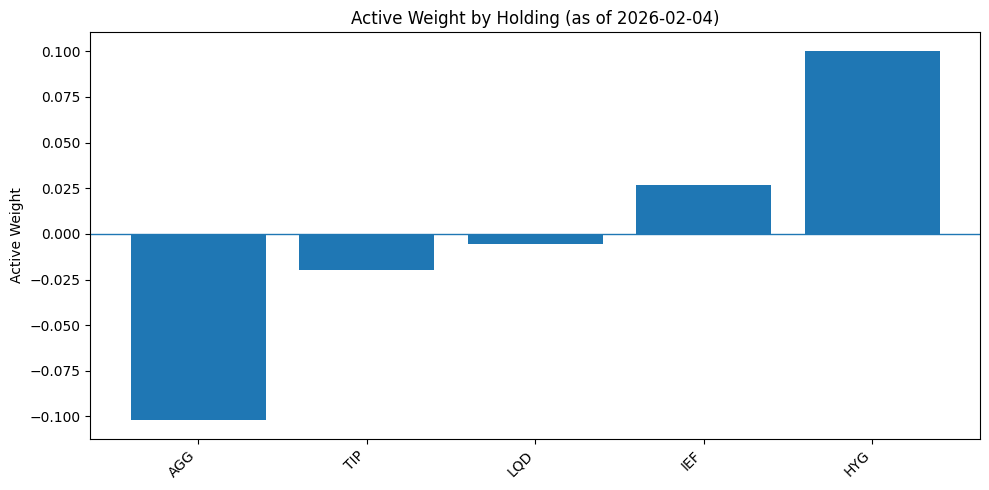

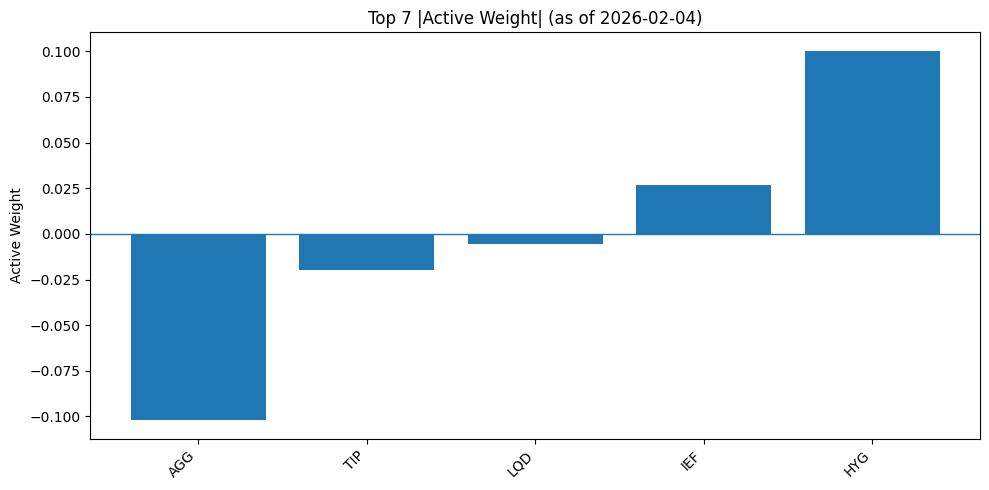

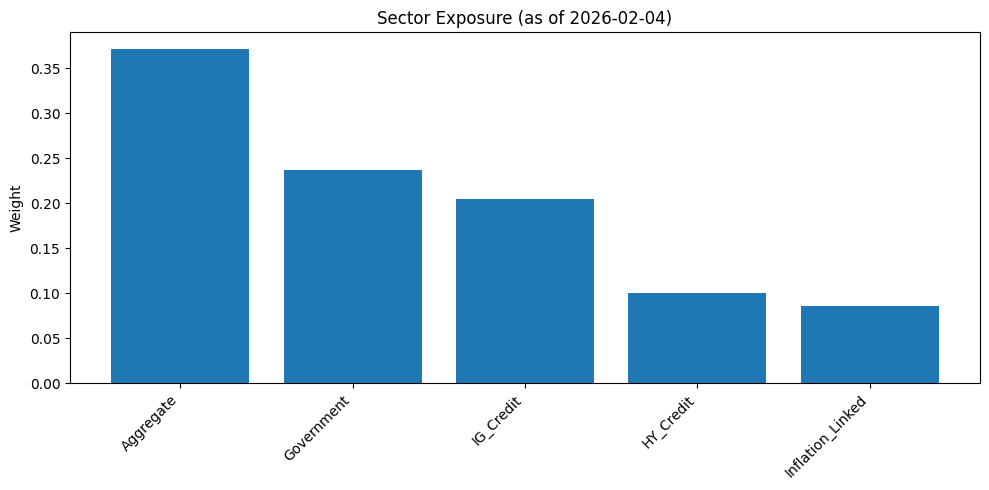

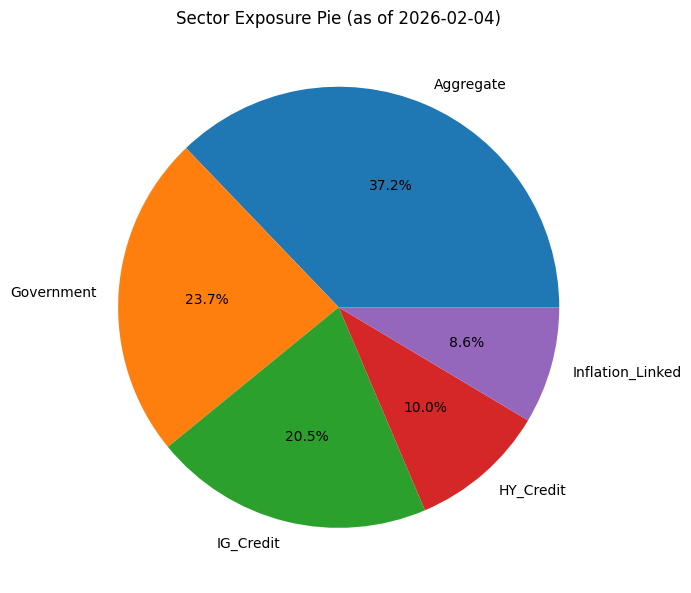

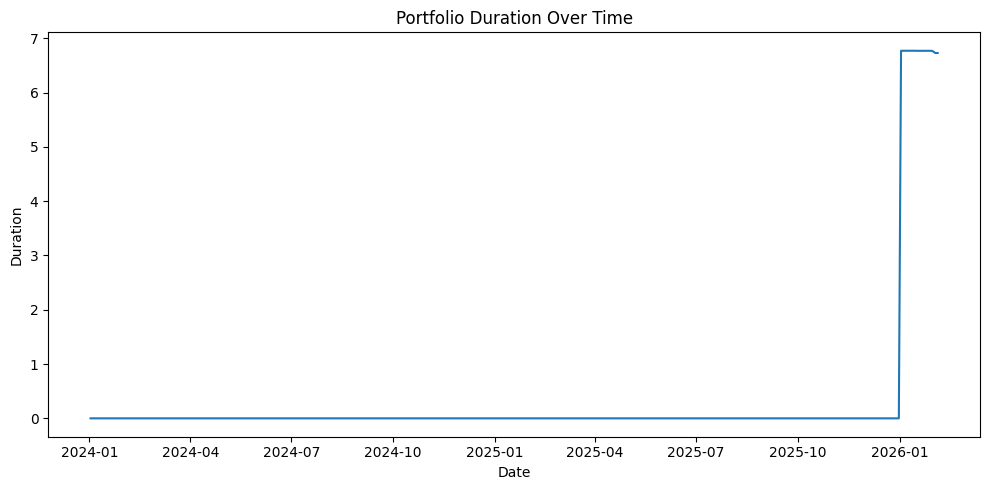

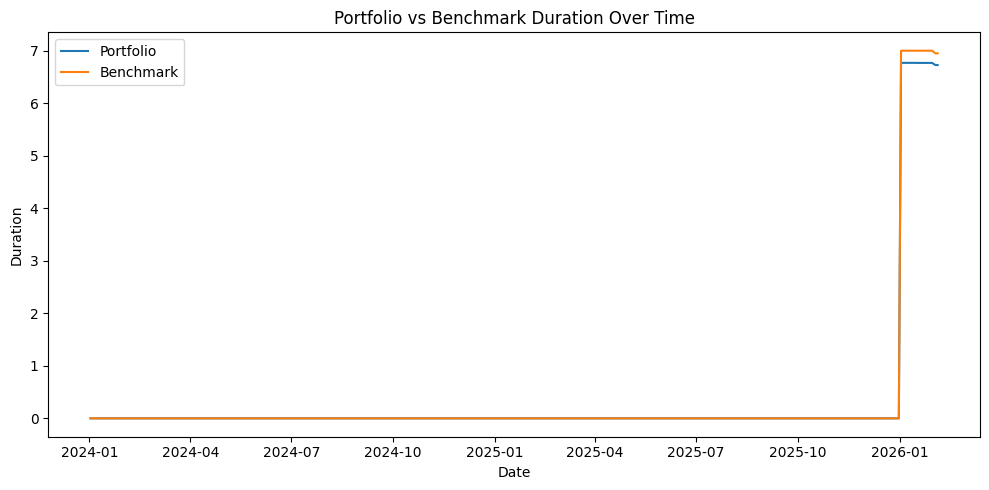

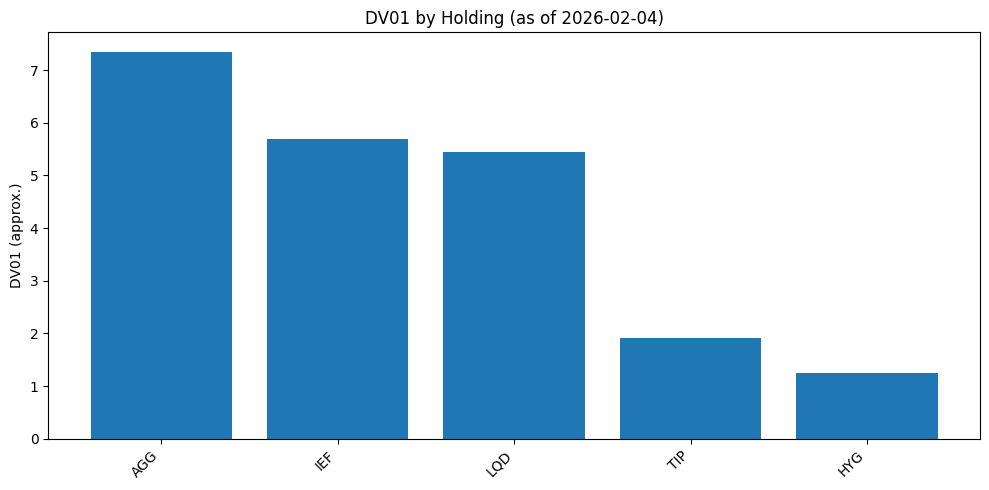

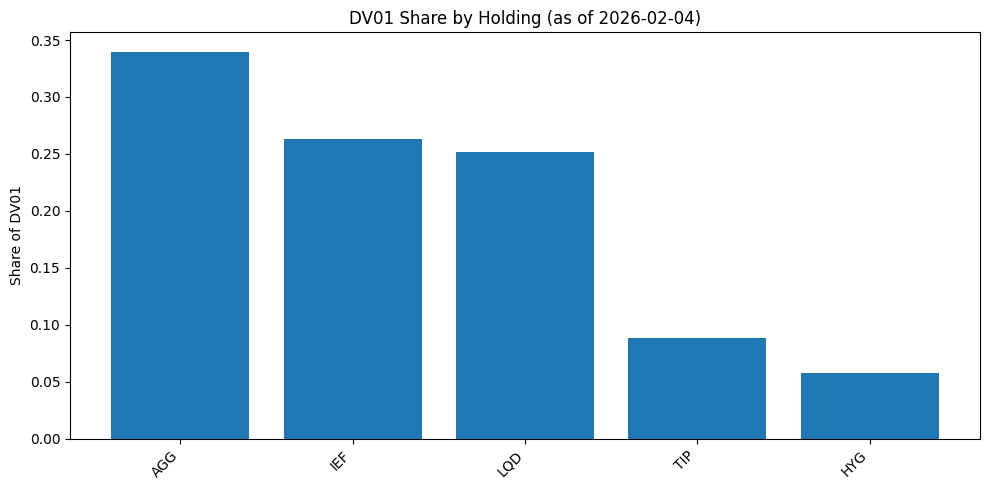

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 確保 asof 存在
asof = px.index.max()

# ---------------------------
# A. Active weight（偏離）長條圖
# ---------------------------
# active_w: daily active weights = weights - bm_w
aw_today = active_w.loc[asof].dropna().sort_values()

plt.figure(figsize=(10, 5))
plt.bar(aw_today.index, aw_today.values)
plt.axhline(0, linewidth=1)
plt.title(f"Active Weight by Holding (as of {asof.date()})")
plt.ylabel("Active Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 你也可以只畫偏離最大前 N 名（更像監控）
N = 7
aw_abs = active_w.loc[asof].dropna()
aw_top = aw_abs.reindex(aw_abs.abs().sort_values(ascending=False).head(N).index)
aw_top = aw_top.sort_values()

plt.figure(figsize=(10, 5))
plt.bar(aw_top.index, aw_top.values)
plt.axhline(0, linewidth=1)
plt.title(f"Top {N} |Active Weight| (as of {asof.date()})")
plt.ylabel("Active Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# ---------------------------
# B. Sector exposure 圖（Bar + Pie）
# ---------------------------

asof = px.index.max()

# 當日權重（穩定版）
today_w = weights.loc[asof].to_frame("weight").reset_index()
today_w.columns = ["sid", "weight"]

# merge 進 sector
tmp = today_w.merge(security_master[["sid","sector"]], on="sid", how="left")

# 如果 sector 有缺，先標成 Unknown（避免 groupby 看起來空白）
tmp["sector"] = tmp["sector"].fillna("Unknown")

sector_expo = tmp.groupby("sector", dropna=False)["weight"].sum().sort_values(ascending=False)

import matplotlib.pyplot as plt

# Bar
plt.figure(figsize=(10, 5))
plt.bar(sector_expo.index.astype(str), sector_expo.values)
plt.title(f"Sector Exposure (as of {asof.date()})")
plt.ylabel("Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Pie
plt.figure(figsize=(7, 7))
plt.pie(sector_expo.values, labels=sector_expo.index.astype(str), autopct="%1.1f%%")
plt.title(f"Sector Exposure Pie (as of {asof.date()})")
plt.tight_layout()
plt.show()

# ---------------------------
# C. Duration time series（投組久期隨時間）
# ---------------------------
# port_duration: daily portfolio duration series
plt.figure(figsize=(10, 5))
plt.plot(port_duration.index, port_duration.values)
plt.title("Portfolio Duration Over Time")
plt.ylabel("Duration")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# 也可以把 benchmark duration 畫成一條水平線，對比更直覺
bm_duration_series = (dur_d.mul(bm_w, axis=1)).sum(axis=1)  # daily bm duration (using daily dur_d)
plt.figure(figsize=(10, 5))
plt.plot(port_duration.index, port_duration.values, label="Portfolio")
plt.plot(bm_duration_series.index, bm_duration_series.values, label="Benchmark")
plt.title("Portfolio vs Benchmark Duration Over Time")
plt.ylabel("Duration")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


# ---------------------------
# D. DV01 by holding 長條圖（今天每檔利率風險貢獻）
# ---------------------------
# dv01: daily DV01 matrix; choose today
dv01_today = dv01.loc[asof].dropna().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(dv01_today.index, dv01_today.values)
plt.title(f"DV01 by Holding (as of {asof.date()})")
plt.ylabel("DV01 (approx.)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 你也可以看 DV01 的占比（哪檔是利率風險主來源）
dv01_share = (dv01_today / dv01_today.sum()).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(dv01_share.index, dv01_share.values)
plt.title(f"DV01 Share by Holding (as of {asof.date()})")
plt.ylabel("Share of DV01")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import numpy as np

# 你目前可用的 base duration（用 2026-01 當基準）
BASE_MONTH = pd.Timestamp("2026-01-01")
BASE_DUR = {
    "AGG": 6.20, "IEF": 7.50, "TLT": 16.80,
    "LQD": 8.30, "HYG": 3.80, "TIP": 7.00, "BIL": 0.10
}

# 你要補齊的月份區間
MONTH_START = "2024-01-01"
MONTH_END   = "2026-02-01"
months = pd.date_range(MONTH_START, MONTH_END, freq="MS")  # MS = month start

# 模擬每月小幅變動（讓它更像真）
# 原則：不讓 duration 劇烈亂跳，只做溫和的月度漂移
rng = np.random.default_rng(42)

rows = []
for m in months:
    # 距離基準月的月數差（例如 2025-12 比 2026-01 少 1）
    diff_m = (m.year - BASE_MONTH.year) * 12 + (m.month - BASE_MONTH.month)
    
    for sid, d0 in BASE_DUR.items():
        # 讓 duration 隨時間有輕微漂移：越遠離 2026-01，允許變動稍微大一點點
        # 你可以把 scale 調小/調大（作品集建議小一點）
        scale = 0.03 + 0.002 * abs(diff_m)   # 基礎波動 + 距離加成
        
        # 生成一個小噪音，並加上一點點 mean-reversion（避免一路飄走）
        noise = rng.normal(0, scale)
        drift = -0.001 * diff_m  # 很小的線性漂移（可改成 0）
        
        d = d0 + noise + drift
        
        # 邏輯約束：duration 不能是負的，BIL 也不該亂跳
        if sid == "BIL":
            d = 0.10  # 現金 proxy 固定 0.10
        else:
            d = max(d, 0.05)
        
        rows.append((m, sid, float(d)))

duration_monthly = pd.DataFrame(rows, columns=["month", "sid", "duration"])
duration_monthly["month"] = pd.to_datetime(duration_monthly["month"])
duration_monthly

,month,sid,duration
0,2024-01-01,AGG,6.247768
1,2024-01-01,IEF,7.442881
2,2024-01-01,TLT,16.882535
3,2024-01-01,LQD,8.397364
4,2024-01-01,HYG,3.671819
...,...,...,...
177,2026-02-01,TLT,16.804120
178,2026-02-01,LQD,8.295204
179,2026-02-01,HYG,3.808146
180,2026-02-01,TIP,7.040792


In [9]:
# 轉成月矩陣：month x sid
dur_m = duration_monthly.pivot(index="month", columns="sid", values="duration").sort_index()

# 對齊到每天：用最近一次月資料 ffill
dur_d = dur_m.reindex(px.index, method="ffill").reindex(columns=TICKERS_USE)


In [10]:
# 重新算投組久期
port_duration = (weights * dur_d).sum(axis=1)

# 重新算 DV01（近似）
dv01 = (mv * dur_d) * 1e-4
port_dv01 = dv01.sum(axis=1)

# benchmark duration 時間序列
bm_duration_series = (dur_d.mul(bm_w, axis=1)).sum(axis=1)


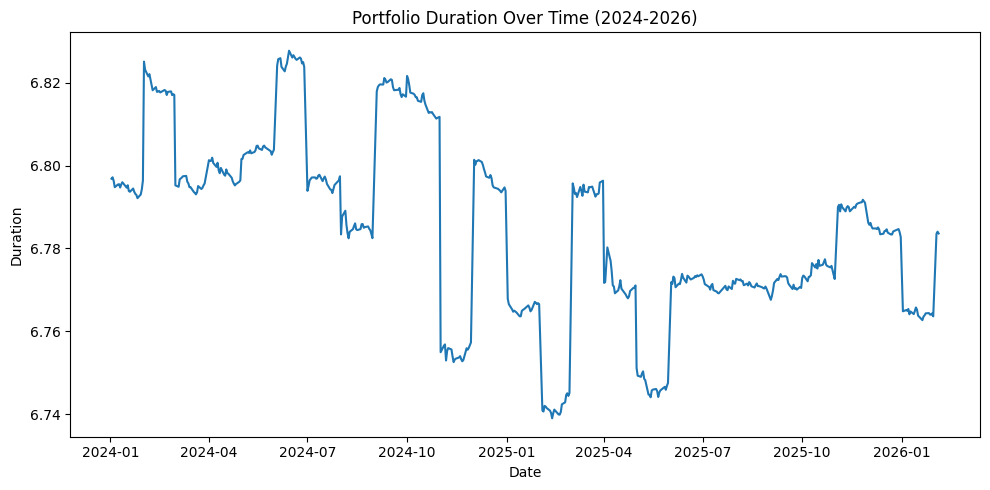

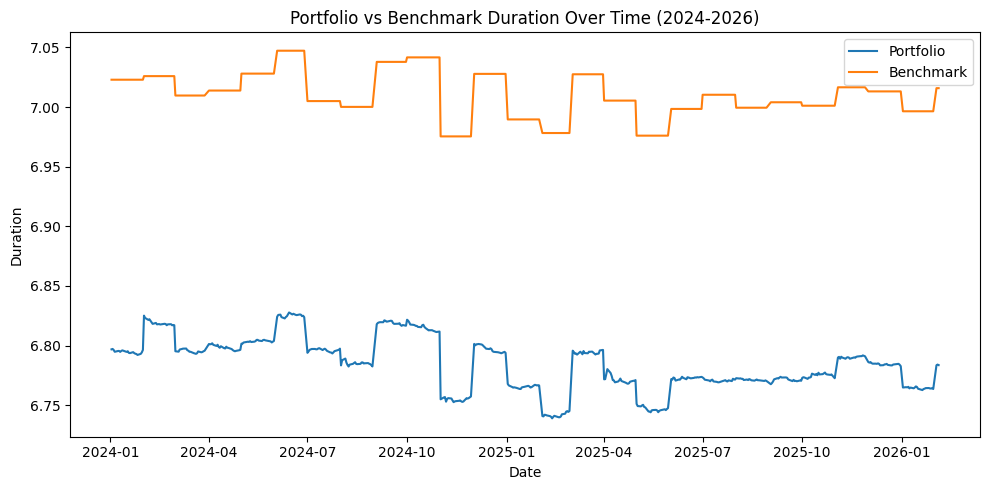

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(port_duration.index, port_duration.values)
plt.title("Portfolio Duration Over Time (2024-2026)")
plt.ylabel("Duration")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(port_duration.index, port_duration.values, label="Portfolio")
plt.plot(bm_duration_series.index, bm_duration_series.values, label="Benchmark")
plt.title("Portfolio vs Benchmark Duration Over Time (2024-2026)")
plt.ylabel("Duration")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


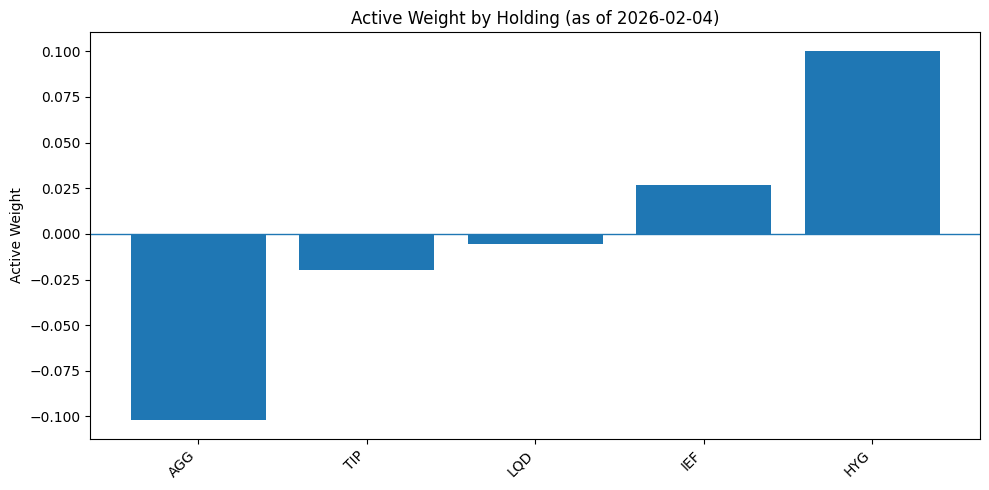

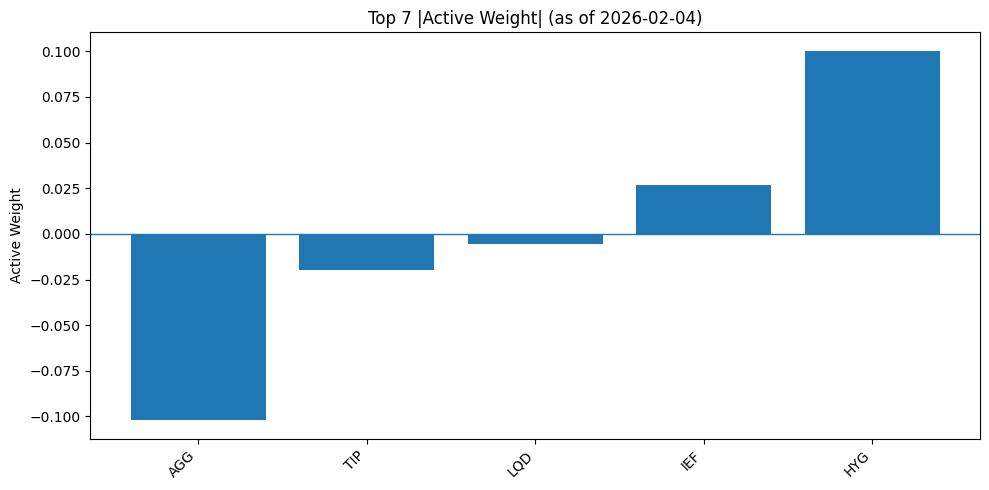

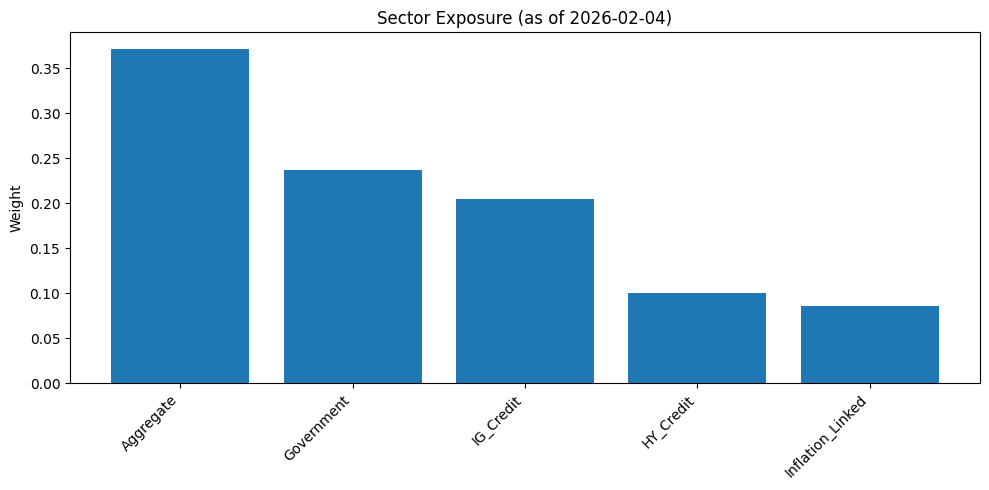

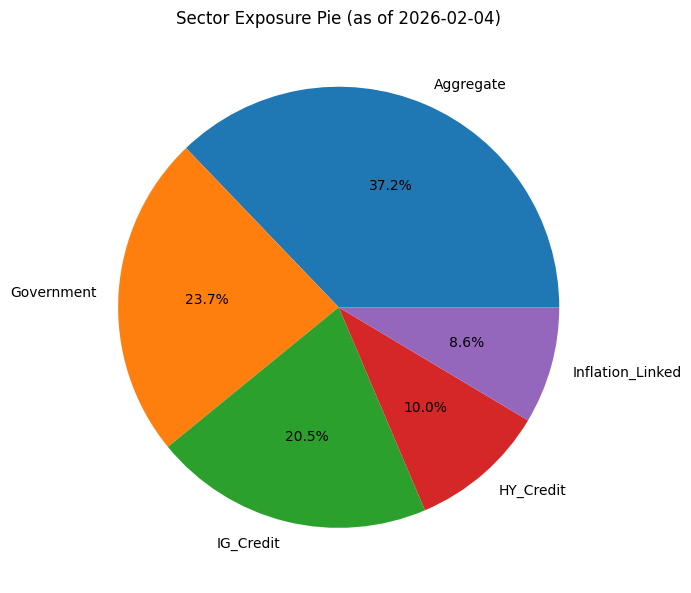

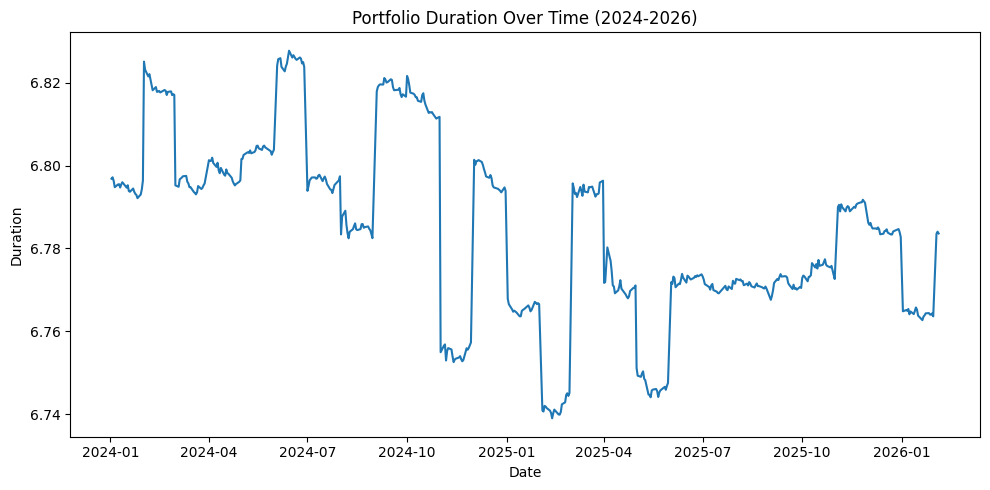

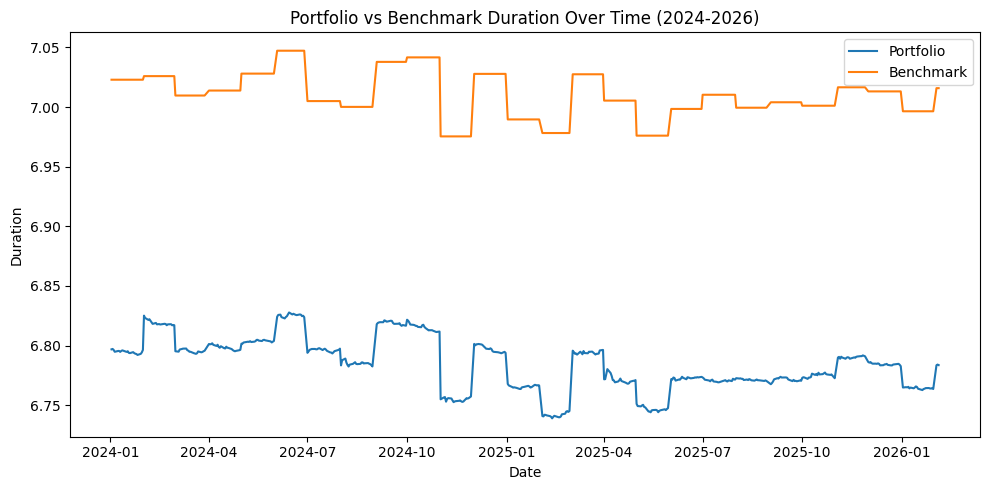

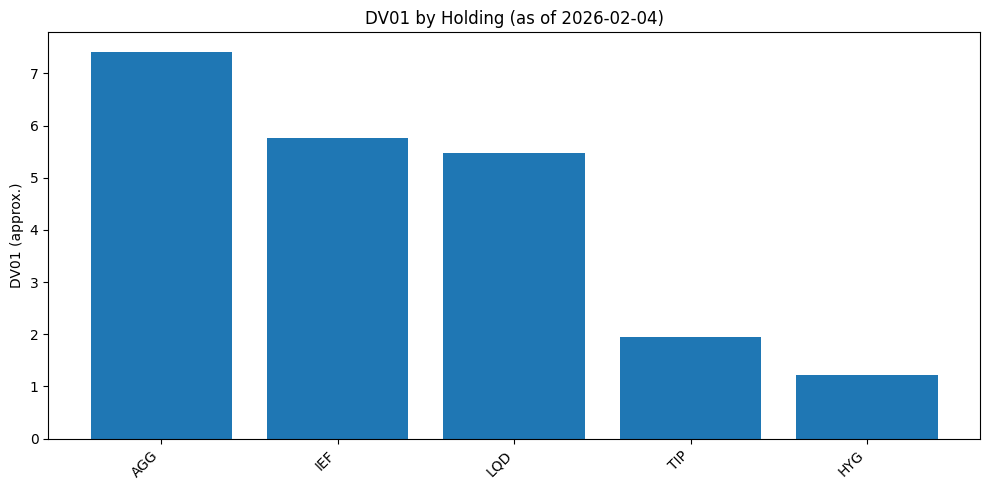

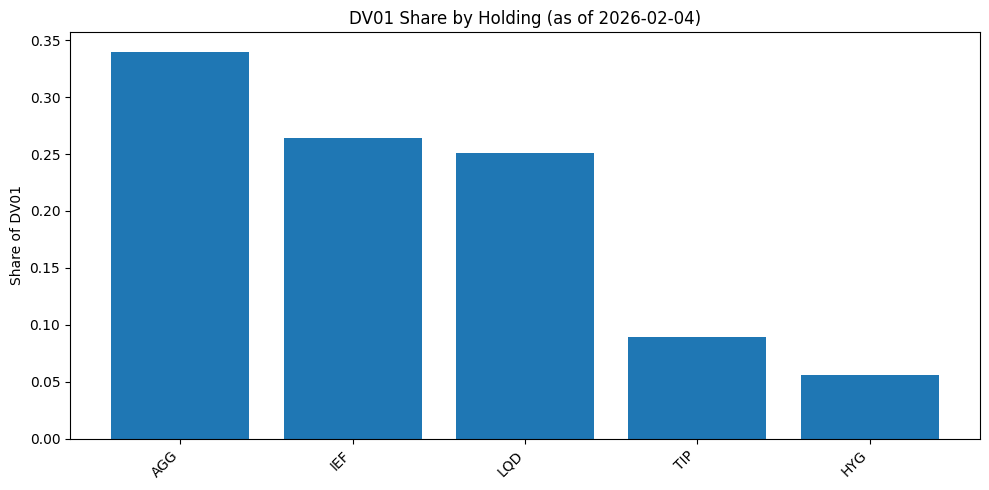

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) 基本設定
# =========================
asof = px.index.max()

# =========================
# 1) 方案2：補齊 2024-2025 的 duration_monthly（更像真）
#    - 用 2026-01 的 duration 當 base
#    - 每月小幅變動（平滑模擬月更因子）
# =========================
BASE_MONTH = pd.Timestamp("2026-01-01")
BASE_DUR = {
    "AGG": 6.20, "IEF": 7.50, "TLT": 16.80,
    "LQD": 8.30, "HYG": 3.80, "TIP": 7.00, "BIL": 0.10
}
MONTH_START = "2024-01-01"
MONTH_END   = "2026-02-01"
months = pd.date_range(MONTH_START, MONTH_END, freq="MS")  # month start

rng = np.random.default_rng(42)

rows = []
for m in months:
    diff_m = (m.year - BASE_MONTH.year) * 12 + (m.month - BASE_MONTH.month)

    for sid, d0 in BASE_DUR.items():
        scale = 0.03 + 0.002 * abs(diff_m)   # 小幅波動 + 距離加成
        noise = rng.normal(0, scale)
        drift = -0.001 * diff_m              # 很小漂移（可改 0）

        d = d0 + noise + drift

        if sid == "BIL":
            d = 0.10                         # 現金 proxy 固定
        else:
            d = max(d, 0.05)                 # duration 不為負

        rows.append((m, sid, float(d)))

duration_monthly = pd.DataFrame(rows, columns=["month", "sid", "duration"])
duration_monthly["month"] = pd.to_datetime(duration_monthly["month"])

# 月矩陣 → 日矩陣（ffill）
dur_m = duration_monthly.pivot(index="month", columns="sid", values="duration").sort_index()
dur_d = dur_m.reindex(px.index, method="ffill").reindex(columns=TICKERS_USE)

# =========================
# 2) 重新計算：port_duration / dv01 / bm_duration_series / active_w
# =========================
active_w = weights.sub(bm_w, axis=1)

port_duration = (weights * dur_d).sum(axis=1)
dv01 = (mv * dur_d) * 1e-4
bm_duration_series = (dur_d.mul(bm_w, axis=1)).sum(axis=1)

# =========================
# 3) A. Active Weight（偏離）長條圖（全體 + TopN）
# =========================
aw_today = active_w.loc[asof].dropna().sort_values()

plt.figure(figsize=(10, 5))
plt.bar(aw_today.index, aw_today.values)
plt.axhline(0, linewidth=1)
plt.title(f"Active Weight by Holding (as of {asof.date()})")
plt.ylabel("Active Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

N = 7
aw_abs = active_w.loc[asof].dropna()
aw_top = aw_abs.reindex(aw_abs.abs().sort_values(ascending=False).head(N).index).sort_values()

plt.figure(figsize=(10, 5))
plt.bar(aw_top.index, aw_top.values)
plt.axhline(0, linewidth=1)
plt.title(f"Top {N} |Active Weight| (as of {asof.date()})")
plt.ylabel("Active Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# =========================
# 4) B. Sector Exposure（Bar + Pie）
# =========================
today_w = weights.loc[asof].to_frame("weight").reset_index()
today_w.columns = ["sid", "weight"]

tmp = today_w.merge(security_master[["sid", "sector"]], on="sid", how="left")
tmp["sector"] = tmp["sector"].fillna("Unknown")

sector_expo = tmp.groupby("sector", dropna=False)["weight"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(sector_expo.index.astype(str), sector_expo.values)
plt.title(f"Sector Exposure (as of {asof.date()})")
plt.ylabel("Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
plt.pie(sector_expo.values, labels=sector_expo.index.astype(str), autopct="%1.1f%%")
plt.title(f"Sector Exposure Pie (as of {asof.date()})")
plt.tight_layout()
plt.show()

# =========================
# 5) C. Duration time series（投組久期 + 與基準對比）
# =========================
plt.figure(figsize=(10, 5))
plt.plot(port_duration.index, port_duration.values)
plt.title("Portfolio Duration Over Time (2024-2026)")
plt.ylabel("Duration")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(port_duration.index, port_duration.values, label="Portfolio")
plt.plot(bm_duration_series.index, bm_duration_series.values, label="Benchmark")
plt.title("Portfolio vs Benchmark Duration Over Time (2024-2026)")
plt.ylabel("Duration")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 6) D. DV01 by holding（今日 DV01 + DV01 share）
# =========================
dv01_today = dv01.loc[asof].dropna().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(dv01_today.index, dv01_today.values)
plt.title(f"DV01 by Holding (as of {asof.date()})")
plt.ylabel("DV01 (approx.)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

dv01_share = (dv01_today / dv01_today.sum()).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(dv01_share.index, dv01_share.values)
plt.title(f"DV01 Share by Holding (as of {asof.date()})")
plt.ylabel("Share of DV01")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


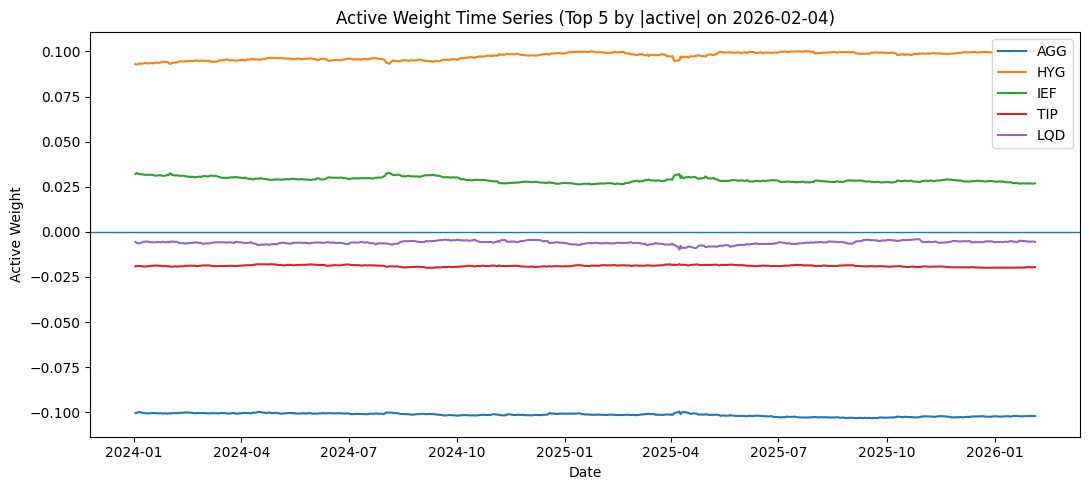

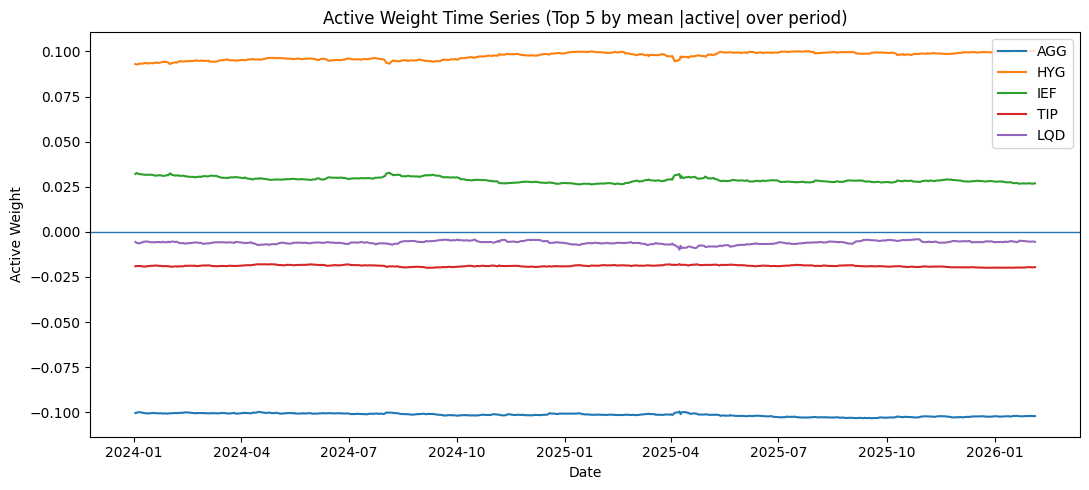

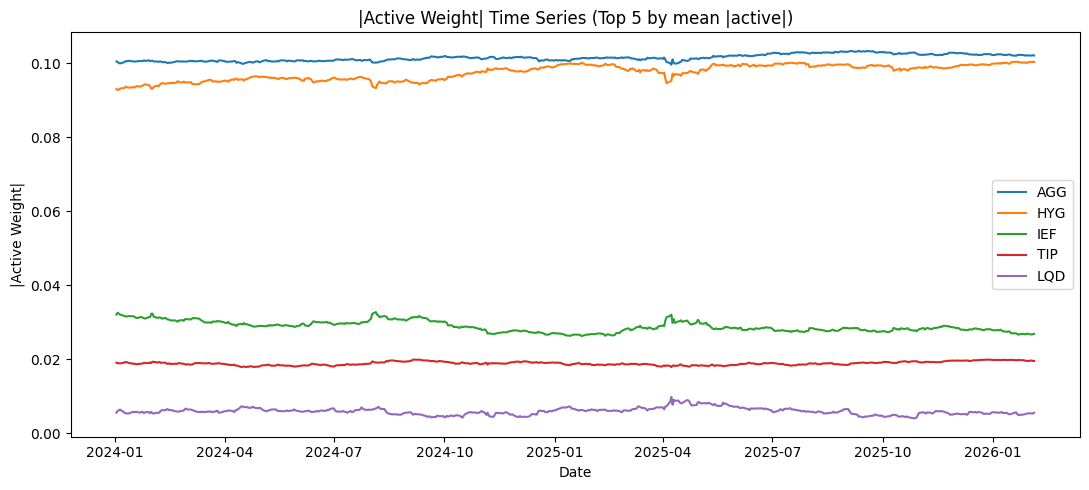

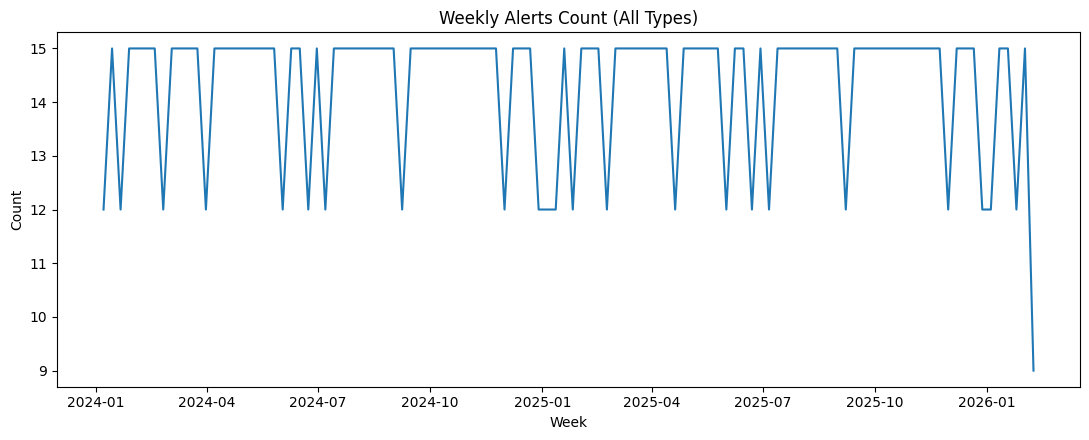

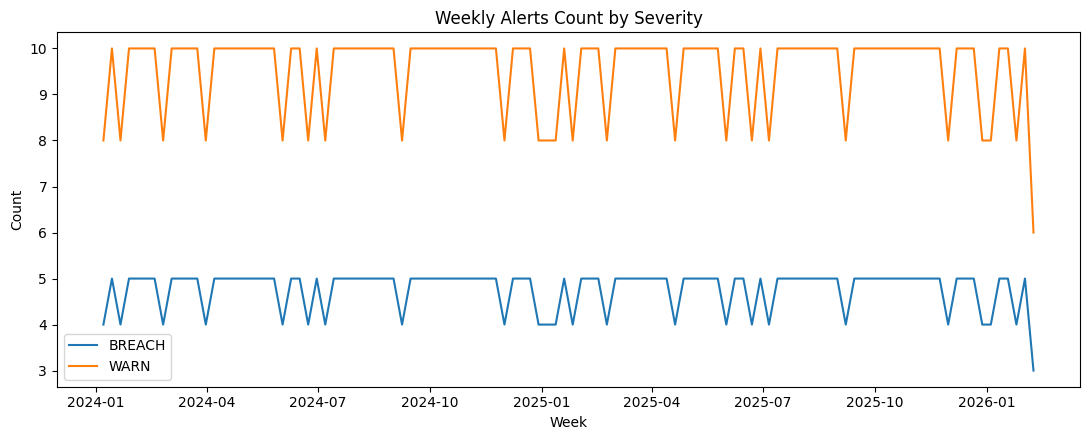

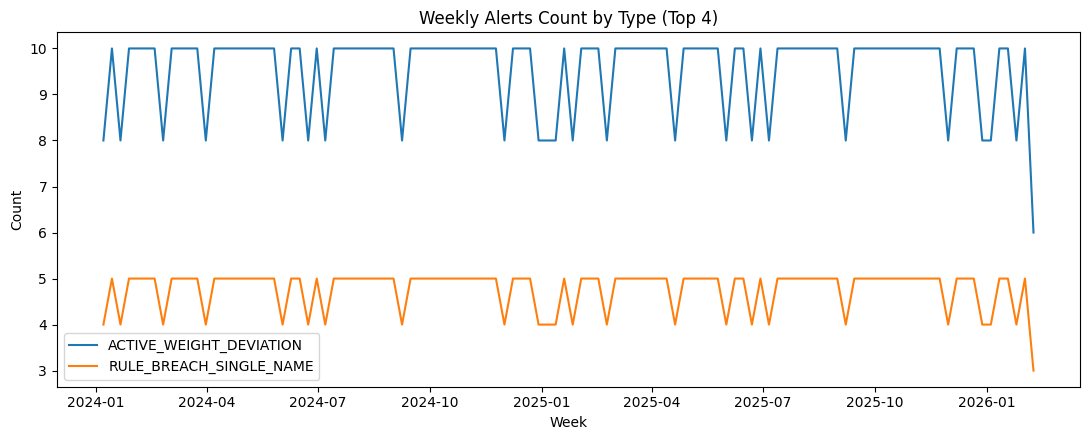

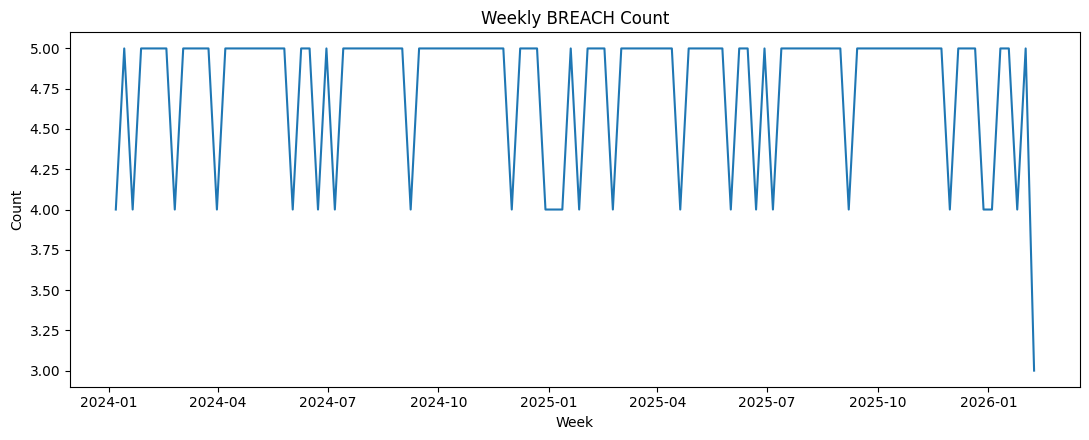

,weekly_total_alerts,weekly_breach
date,,
2025-11-23,15,5
2025-11-30,12,4
2025-12-07,15,5
2025-12-14,15,5
2025-12-21,15,5
2025-12-28,12,4
2026-01-04,12,4
2026-01-11,15,5
2026-01-18,15,5


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 7) Active weight time series（只畫偏離最大的幾檔）
# =========================
asof = px.index.max()

# --- 選法 1：以「最新日」偏離最大 Top N ---
TOP_N = 5
aw_today = active_w.loc[asof].dropna()
top_sids_latest = aw_today.abs().sort_values(ascending=False).head(TOP_N).index.tolist()

aw_ts_latest = active_w[top_sids_latest].copy()

plt.figure(figsize=(11, 5))
for sid in aw_ts_latest.columns:
    plt.plot(aw_ts_latest.index, aw_ts_latest[sid].values, label=sid)
plt.axhline(0, linewidth=1)
plt.title(f"Active Weight Time Series (Top {TOP_N} by |active| on {asof.date()})")
plt.ylabel("Active Weight")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

# --- 選法 2：以「全期間平均絕對偏離」挑 Top N（更像監控：長期最偏的標的） ---
aw_abs_mean = active_w.abs().mean().sort_values(ascending=False)
top_sids_mean = aw_abs_mean.head(TOP_N).index.tolist()

aw_ts_mean = active_w[top_sids_mean].copy()

plt.figure(figsize=(11, 5))
for sid in aw_ts_mean.columns:
    plt.plot(aw_ts_mean.index, aw_ts_mean[sid].values, label=sid)
plt.axhline(0, linewidth=1)
plt.title(f"Active Weight Time Series (Top {TOP_N} by mean |active| over period)")
plt.ylabel("Active Weight")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

# （可選）加一張：Top N 的 |active|（絕對值）時間序列，更像「偏離壓力」
aw_abs_ts = active_w[top_sids_mean].abs()

plt.figure(figsize=(11, 5))
for sid in aw_abs_ts.columns:
    plt.plot(aw_abs_ts.index, aw_abs_ts[sid].values, label=sid)
plt.title(f"|Active Weight| Time Series (Top {TOP_N} by mean |active|)")
plt.ylabel("|Active Weight|")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


# =========================
# 8) Alerts 趨勢圖（每週 breach 幾次）
#    我們用每天的 weights/active/port_duration 去重建「每日 alerts」
# =========================

# 你原本 one-click 有 LIMITS；如果沒有就給預設（避免 NameError）
if "LIMITS" not in globals():
    LIMITS = {
        "MAX_SINGLE_NAME_WEIGHT": 0.35,
        "DURATION_LOW": 4.0,
        "DURATION_HIGH": 8.0,
        "MIN_CASH_WEIGHT": 0.03,       # treat BIL as cash proxy
        "ACTIVE_WEIGHT_WARN": 0.05,
    }

MAX_W = float(LIMITS["MAX_SINGLE_NAME_WEIGHT"])
MIN_CASH = float(LIMITS["MIN_CASH_WEIGHT"])
AW_WARN = float(LIMITS["ACTIVE_WEIGHT_WARN"])
D_LOW = float(LIMITS["DURATION_LOW"])
D_HIGH = float(LIMITS["DURATION_HIGH"])

# 需要：port_duration, weights, active_w
# （如果你沒先算 port_duration，這裡會炸；你前面方案2已經算了）
# port_duration: Series
# weights: DataFrame daily
# active_w: DataFrame daily

# 建 alerts 的 function（每日多筆）
alerts_rows = []

# --- 1) 單一標的超限：每一天找出 weight > MAX_W 的標的 ---
breach_single = weights.gt(MAX_W)
for dt, row in breach_single.iterrows():
    sids = row[row].index.tolist()
    for sid in sids:
        alerts_rows.append({
            "date": dt,
            "severity": "BREACH",
            "alert_type": "RULE_BREACH_SINGLE_NAME",
            "sid": sid,
            "value": float(weights.loc[dt, sid]),
            "threshold": MAX_W
        })

# --- 2) 現金不足：用 BIL 當 cash proxy（若無 BIL 欄位就跳過） ---
if "BIL" in weights.columns:
    cash_w = weights["BIL"].copy()
    breach_cash = cash_w.lt(MIN_CASH)
    for dt in cash_w.index[breach_cash]:
        alerts_rows.append({
            "date": dt,
            "severity": "WARN",
            "alert_type": "RULE_BREACH_MIN_CASH",
            "sid": "BIL",
            "value": float(cash_w.loc[dt]),
            "threshold": MIN_CASH
        })

# --- 3) 久期超出範圍（低於/高於） ---
for dt, d in port_duration.dropna().items():
    if d < D_LOW:
        alerts_rows.append({
            "date": dt,
            "severity": "BREACH",
            "alert_type": "RULE_BREACH_DURATION_LOW",
            "sid": "",
            "value": float(d),
            "threshold": D_LOW
        })
    if d > D_HIGH:
        alerts_rows.append({
            "date": dt,
            "severity": "BREACH",
            "alert_type": "RULE_BREACH_DURATION_HIGH",
            "sid": "",
            "value": float(d),
            "threshold": D_HIGH
        })

# --- 4) Active weight 偏離過大：|active| > AW_WARN ---
aw_abs = active_w.abs()
aw_flag = aw_abs.gt(AW_WARN)

for dt, row in aw_flag.iterrows():
    sids = row[row].index.tolist()
    for sid in sids:
        alerts_rows.append({
            "date": dt,
            "severity": "WARN",
            "alert_type": "ACTIVE_WEIGHT_DEVIATION",
            "sid": sid,
            "value": float(active_w.loc[dt, sid]),
            "threshold": AW_WARN
        })

alerts_ts = pd.DataFrame(alerts_rows)
alerts_ts["date"] = pd.to_datetime(alerts_ts["date"])

# 如果整段期間都沒 alerts，避免後面 groupby 爆
if len(alerts_ts) == 0:
    print("No alerts generated for the selected period/rules.")
else:
    # =========================
    # 8-1) 每週 alerts 總數（最直覺）
    # =========================
    weekly_total = alerts_ts.set_index("date").resample("W")["alert_type"].count()

    plt.figure(figsize=(11, 4.5))
    plt.plot(weekly_total.index, weekly_total.values)
    plt.title("Weekly Alerts Count (All Types)")
    plt.ylabel("Count")
    plt.xlabel("Week")
    plt.tight_layout()
    plt.show()

    # =========================
    # 8-2) 每週依 severity 分類（WARN vs BREACH）
    # =========================
    weekly_by_sev = (
        alerts_ts
        .set_index("date")
        .groupby("severity")["alert_type"]
        .resample("W")
        .count()
        .unstack(0)
        .fillna(0)
    )

    plt.figure(figsize=(11, 4.5))
    for col in weekly_by_sev.columns:
        plt.plot(weekly_by_sev.index, weekly_by_sev[col].values, label=col)
    plt.title("Weekly Alerts Count by Severity")
    plt.ylabel("Count")
    plt.xlabel("Week")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # =========================
    # 8-3) 每週依 alert_type 分類（哪種問題最常發生）
    # =========================
    weekly_by_type = (
        alerts_ts
        .set_index("date")
        .groupby("alert_type")["severity"]
        .resample("W")
        .count()
        .unstack(0)
        .fillna(0)
    )

    # 只畫最常出現的前 K 種 alert_type（避免線太多）
    TOP_K_TYPES = 4
    top_types = weekly_by_type.sum(axis=0).sort_values(ascending=False).head(TOP_K_TYPES).index.tolist()
    weekly_top_types = weekly_by_type[top_types]

    plt.figure(figsize=(11, 4.5))
    for col in weekly_top_types.columns:
        plt.plot(weekly_top_types.index, weekly_top_types[col].values, label=col)
    plt.title(f"Weekly Alerts Count by Type (Top {TOP_K_TYPES})")
    plt.ylabel("Count")
    plt.xlabel("Week")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # =========================
    # 8-4) （可選）每週 BREACH 次數（面試很愛看）
    # =========================
    weekly_breach = alerts_ts[alerts_ts["severity"] == "BREACH"].set_index("date").resample("W")["alert_type"].count()

    plt.figure(figsize=(11, 4.5))
    plt.plot(weekly_breach.index, weekly_breach.values)
    plt.title("Weekly BREACH Count")
    plt.ylabel("Count")
    plt.xlabel("Week")
    plt.tight_layout()
    plt.show()

    # 額外：把 weekly 統計表印出來（你要寫 README 可以用）
    display(pd.DataFrame({
        "weekly_total_alerts": weekly_total,
        "weekly_breach": weekly_breach.reindex(weekly_total.index).fillna(0)
    }).tail(12))
